# ***WGAN + anime***
Implementación de WGAN con TensorFlow / Keras, entrenada para generar caras de anime de 64x64. Entrenaremos el modelo WGAN en un conjunto de datos llamado Anime Face Dataset de Kaggle, que es una colección de caras de anime, extraídas de www.getchu.com.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import numpy as np
import os

In [36]:
os.environ['KAGGLE_USERNAME']="USUARIO"
os.environ['KAGGLE_KEY']="API_KEY"

In [37]:
# descargar dataset de kaggle en la ruta 'datasets/
!kaggle datasets download -d splcher/animefacedataset -p datasets

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
!unzip datasets/animefacedataset.zip -d datasets/

Archive:  datasets/animefacedataset.zip
replace datasets/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [39]:
anime_directorio = "/content/datasets/images"

In [40]:
imagenes_entrenamiento = tf.keras.utils.image_dataset_from_directory(
    anime_directorio, label_mode=None, image_size=(64, 64), batch_size=256 # tamaño del batch, actualizado de 32
)

Found 63565 files.


## ***Visualización***
Siempre me gusta visualizar los datos de entrenamiento para hacerme una idea de cómo son.

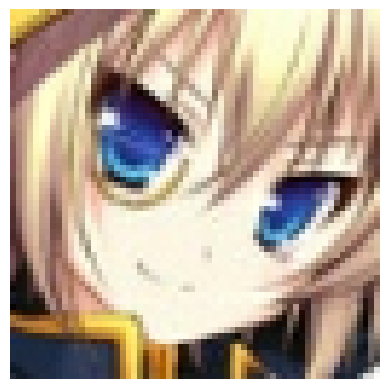

In [44]:
# Obtener un lote de imágenes del dataset de entrenamiento
lote_imagenes = next(iter(imagenes_entrenamiento))
indice_aleatorio = np.random.choice(lote_imagenes.shape[0])
imagen_aleatoria = lote_imagenes[indice_aleatorio].numpy().astype("int32")

# Mostrar la imagen seleccionada
plt.axis("off")
plt.imshow(imagen_aleatoria)
plt.show()

In [42]:
def mostrar(imagenes):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)  # Crear subgráfico 4x4, posición i+1
        img = keras.utils.array_to_img(imagenes[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

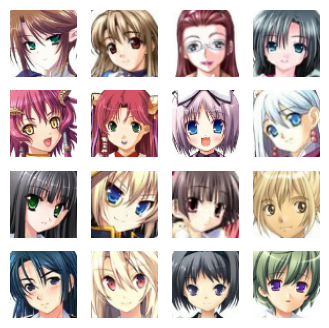

In [45]:
# 16 imagenes del dataset
mostrar(lote_imagenes[:16])

In [46]:
# Normalizar las imágenes al rango [-1, 1] que es el rango de la activación tanh
imagenes_entrenamiento = imagenes_entrenamiento.map(lambda x: (x - 127.5) / 127.5)

## ***Generador***
Define la arquitectura del modelo generador con la API Secuencial de Keras. Usa ReLU excepto para la última capa que tiene tanh como activación. El trabajo del generador es crear imágenes: introducimos ruido aleatorio como entrada al generador e irá amplificandose hasta que el tamaño de imagen deseado sea 64x64x3.

In [47]:
# Dimensión del espacio latente para el ruido aleatorio
DIM_LATENTE = 128

# Inicializador de pesos para el generador DCGAN
PESOS_INI = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Número de canales: 1 para escala de grises, 3 para imágenes a color
CANALES = 3

In [48]:
def construir_generador():
    # Crear modelo secuencial de Keras
    model = Sequential(name="generador")

    # Preparar para reshape: Capas FC => BN => RN
    model.add(layers.Dense(8 * 8 * 512, input_dim=DIM_LATENTE))
    model.add(layers.ReLU())

    # Convertir 1D a 3D: remodelar la salida de la capa anterior
    model.add(layers.Reshape((8, 8, 512)))

    # Upsample a 16x16: aplicar CONV transpuesta => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4),
                                   strides=(2, 2),
                                   padding="same",
                                   use_bias=False,
                                   kernel_initializer=PESOS_INI))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Upsample a 32x32: aplicar CONV transpuesta => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4),
                                   strides=(2, 2),
                                   padding="same",
                                   use_bias=False,
                                   kernel_initializer=PESOS_INI))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Upsample a 64x64: aplicar CONV transpuesta => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4),
                                   strides=(2, 2),
                                   padding="same",
                                   use_bias=False,
                                   kernel_initializer=PESOS_INI))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Capa final: Conv2D con activación tanh
    model.add(layers.Conv2D(CANALES, (4, 4),
                          padding="same",
                          activation="tanh"))

    return model

In [49]:
generador = construir_generador()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
generador.summary()

Model: "generador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,984,451 (26.64 MB)

 Trainable params: 6,983,555 (26.64 MB)

 Non-trainable params: 896 (3.50 KB)

## ***Crítico***
En WGAN tenemos un crítico en lugar de un discriminador.

In [51]:
# ACTUALIZACIÓN para WGAN: nueva clase que implementa la restricción de recorte de pesos
class WeightClipping(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

    def get_config(self):
        # Configuración para serialización
        return {'clip_value': self.clip_value}

In [52]:
def construir_critico(altura, ancho, profundidad, alpha=0.2):
    # ACTUALIZACIÓN para WGAN: fuerza la restricción 1-Lipschitz con recorte de pesos a [-0.01, 0.01]
    restriccion = WeightClipping(0.01)

    modelo = Sequential(name="critico")
    forma_entrada = (altura, ancho, profundidad)

    # 1. Primer bloque de capas: CONV => LeakyReLU
    modelo.add(layers.Conv2D(64, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint=restriccion,
                            input_shape=forma_entrada))
    modelo.add(layers.LeakyReLU(alpha=alpha))

    # 2. Segundo bloque de capas: CONV => LeakyReLU
    modelo.add(layers.Conv2D(128, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint=restriccion))
    modelo.add(layers.LeakyReLU(alpha=alpha))

    # 3. Tercer bloque de capas: CONV => LeakyReLU
    modelo.add(layers.Conv2D(128, (4, 4), padding="same",
                            strides=(2, 2),
                            kernel_constraint=restriccion))
    modelo.add(layers.LeakyReLU(alpha=alpha))

    modelo.add(layers.Flatten())
    modelo.add(layers.Dropout(0.3))

    # ACTUALIZACIÓN para WGAN: activación lineal en la última capa
    # Nota: La capa Dense de Keras ya tiene activación lineal por defecto
    modelo.add(layers.Dense(1, activation="linear"))

    return modelo

In [53]:
critico = construir_critico(64,64,3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [54]:
critico.summary()

Model: "critico"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## ***WGAN***
Subclase keras.Model para implementar WGAN y anular train_step() para entrenar el crítico y el generador en WGAN.

In [55]:
class WGAN(keras.Model):
    def __init__(self,
                 critico,
                 generador,
                 dim_latente,
                 pasos_extra_critico):  # ACTUALIZACIÓN para WGAN
        super().__init__()
        self.critico = critico
        self.generador = generador
        self.dim_latente = dim_latente
        self.pasos_extra = pasos_extra_critico
        self.metrica_perdida_d = keras.metrics.Mean(name="perdida_d")
        self.metrica_perdida_g = keras.metrics.Mean(name="perdida_g")

    def compile(self, optimizador_d, optimizador_g, fn_perdida_d, fn_perdida_g):
        super(WGAN, self).compile()
        self.optimizador_d = optimizador_d
        self.optimizador_g = optimizador_g
        self.fn_perdida_d = fn_perdida_d
        self.fn_perdida_g = fn_perdida_g

    @property
    def metrics(self):
        return [self.metrica_perdida_d, self.metrica_perdida_g]

    # ACTUALIZACIÓN para WGAN: se elimina el código de etiquetas reales/falsas
    def train_step(self, imagenes_reales):
        tamano_lote = tf.shape(imagenes_reales)[0]
        ruido = tf.random.normal(shape=(tamano_lote, self.dim_latente))

        # ACTUALIZACIÓN para WGAN: el crítico se entrena más veces que el generador
        for i in range(self.pasos_extra):
            # Paso 1. Entrenar el crítico con imágenes reales y falsas
            with tf.GradientTape() as cinta:
                pred_real = self.critico(imagenes_reales, training=True)
                imagenes_falsas = self.generador(ruido, training=True)
                pred_falso = self.critico(imagenes_falsas, training=True)
                perdida_d = self.fn_perdida_d(pred_real, pred_falso)

            gradientes = cinta.gradient(perdida_d, self.critico.trainable_variables)
            self.optimizador_d.apply_gradients(zip(gradientes, self.critico.trainable_variables))

        # Paso 2. Entrenar el generador (sin actualizar pesos del crítico)
        with tf.GradientTape() as cinta:
            imagenes_falsas = self.generador(ruido, training=True)
            pred_falso = self.critico(imagenes_falsas, training=True)
            perdida_g = self.fn_perdida_g(pred_falso)

        gradientes = cinta.gradient(perdida_g, self.generador.trainable_variables)
        self.optimizador_g.apply_gradients(zip(gradientes, self.generador.trainable_variables))

        self.metrica_perdida_d.update_state(perdida_d)
        self.metrica_perdida_g.update_state(perdida_g)

        return {"perdida_d": self.metrica_perdida_d.result(),
                "perdida_g": self.metrica_perdida_g.result()}

## ***Usar Keras Callback para seguir el entrenamiento***
Lo bueno de overriding train_step() de keras.Model() es que podemos subclasificar Callback para monitorear el entrenamiento DCGAN.

Yo uso el ruido semilla para crear imágenes (con el modelo generador) a lo largo del entrenamiento para ver el progreso que va haciendo el generador. También guardo el modelo generador al final del entrenamiento que potencialmente podría ser utilizado para la inferencia luego.

In [56]:
class MonitorGAN(keras.callbacks.Callback):
    def __init__(self, num_img=3, dim_latente=100):
        self.num_img = num_img          # Número de imágenes a generar
        self.dim_latente = dim_latente  # Dimensión del espacio latente

        self.semilla = tf.random.normal([16, dim_latente])

    def on_epoch_end(self, epoch, logs=None):
        """Callback al final de cada época: genera y guarda imágenes"""
        # Generar imágenes a partir del ruido latente
        imagenes_generadas = self.model.generador(self.semilla)

        # Escalar imágenes de [-1, 1] a [0, 255]
        imagenes_generadas = (imagenes_generadas * 127.5) + 127.5
        imagenes_generadas.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(imagenes_generadas[i])
            plt.imshow(img)
            plt.axis('off')

        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        """Callback al final del entrenamiento: guarda el generador"""
        self.model.generador.save('generador.h5')

## ***Compilar y entrenar WGAN***
Compilar el modelo wgan con el optimizador RMSprop (a una tasa de aprendizaje de 0.00005), y la pérdida de Wasserstein.
### Montaje del modelo wgan

In [57]:
wgan = WGAN(
    critico=critico,
    generador=generador,
    dim_latente=DIM_LATENTE,
    pasos_extra_critico=5
)

## Pérdida de Wasserstein

In [58]:
def perdida_d_wasserstein(pred_real, pred_falso):
    perdida_real = tf.reduce_mean(pred_real)      # Promedio predicciones reales
    perdida_falsa = tf.reduce_mean(pred_falso)    # Promedio predicciones falsas
    return perdida_falsa - perdida_real           # Diferencia crítica para WGAN


def perdida_g_wasserstein(pred_falso):
    return -tf.reduce_mean(pred_falso)  # Negativo porque queremos maximizar la calidad

In [59]:
TAZA_APRENDIZAJE = 0.00005

In [60]:
wgan.compile(
    optimizador_d=keras.optimizers.RMSprop(
        learning_rate=TAZA_APRENDIZAJE,
        clipvalue=1.0,
        decay=1e-8
    ),

    # Optimizador para el generador (también RMSprop)
    optimizador_g=keras.optimizers.RMSprop(
        learning_rate=TAZA_APRENDIZAJE,
        clipvalue=1.0,
        decay=1e-8
    ),

    fn_perdida_d=perdida_d_wasserstein,
    fn_perdida_g=perdida_g_wasserstein
)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


##***Entrenar WGAN***

Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - perdida_d: -1.7034 - perdida_g: -1.0086

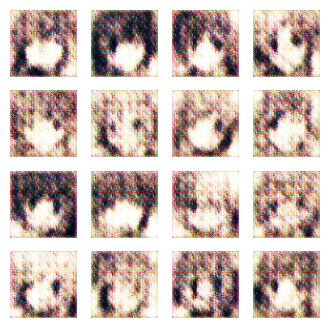

249/249 ━━━━━━━━━━━━━━━━━━━━ 174s 614ms/step - perdida_d: -1.7063 - perdida_g: -1.0099
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - perdida_d: -9.8104 - perdida_g: -16.5902

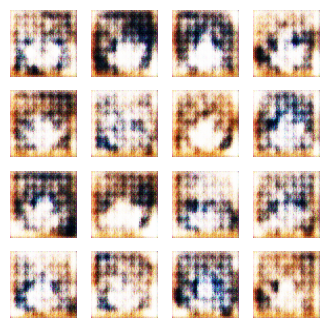

249/249 ━━━━━━━━━━━━━━━━━━━━ 177s 562ms/step - perdida_d: -9.8365 - perdida_g: -16.5990
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - perdida_d: -36.5774 - perdida_g: -28.0673

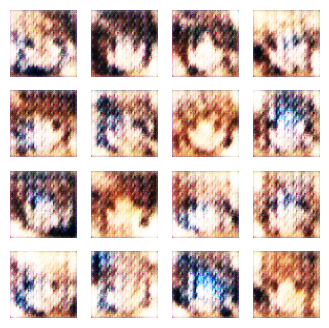

249/249 ━━━━━━━━━━━━━━━━━━━━ 141s 560ms/step - perdida_d: -36.6070 - perdida_g: -28.0846
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - perdida_d: -72.5183 - perdida_g: -30.5595

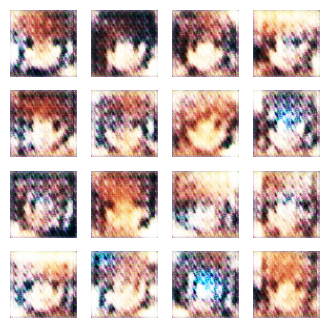

249/249 ━━━━━━━━━━━━━━━━━━━━ 140s 561ms/step - perdida_d: -72.5581 - perdida_g: -30.5744
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - perdida_d: -103.9288 - perdida_g: -25.1124

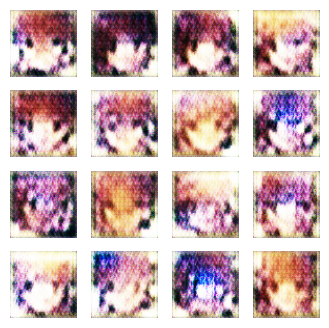

249/249 ━━━━━━━━━━━━━━━━━━━━ 139s 560ms/step - perdida_d: -103.9623 - perdida_g: -25.1178


In [61]:
wgan.fit(
    imagenes_entrenamiento,  # Dataset de imágenes para entrenamiento
    epochs=5,       # Cantidad de iteraciones completas sobre el dataset
    callbacks=[MonitorGAN(num_img=16, dim_latente=DIM_LATENTE)]  # Callback para visualización
)